# Contextual Expected Goals (CxG) Visualisation

**Purpose:** Publication-quality visualisations comparing baseline StatsBomb xG with our Contextual xG model.

This notebook produces clean, portfolio-ready figures that demonstrate:
1. How CxG adjusts shot values compared to baseline xG
2. Model calibration and reliability
3. Performance improvements in specific game contexts (e.g., under pressure)

## 1. Setup and Configuration

In [1]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Football pitch visualisation
from mplsoccer import Pitch, VerticalPitch

# Calibration and metrics
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Configure clean, minimal plotting style for portfolio visuals
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'axes.grid': False,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'figure.dpi': 100,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.pad_inches': 0.1
})

# Output directory for figures
OUTPUT_DIR = Path('../outputs/analysis/cxg/plots')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("✓ Libraries loaded and style configured")

✓ Libraries loaded and style configured


## 2. Load and Prepare Data

In [2]:
# Load the scored CxG dataset
DATA_PATH = Path('../outputs/modeling/cxg/prediction_runs/neutral_priors_refresh_model/scored_shots.parquet')

df = pd.read_parquet(DATA_PATH)

# Rename columns to match expected schema
df = df.rename(columns={
    'cxg_prediction': 'cxg_pred',
    'pressure_state': 'under_pressure'
})

# Convert pressure state to boolean
df['under_pressure'] = df['under_pressure'] == 'Under pressure'

# Validate required columns exist
required_cols = ['location_x', 'location_y', 'statsbomb_xg', 'cxg_pred', 
                 'is_goal', 'under_pressure', 'shot_distance', 'minute', 'chain_label']
missing = [c for c in required_cols if c not in df.columns]
if missing:
    raise ValueError(f"Missing columns: {missing}")

print(f"✓ Loaded {len(df):,} shots")
print(f"  Goals: {df['is_goal'].sum():,} ({100*df['is_goal'].mean():.1f}%)")
print(f"  Under pressure: {df['under_pressure'].sum():,} ({100*df['under_pressure'].mean():.1f}%)")
print(df)

✓ Loaded 15,423 shots
  Goals: 1,421 (9.2%)
  Under pressure: 3,395 (22.0%)
       shot_id  match_id  team_id  opponent_team_id player_id  is_home  \
0            1         1        3                 2      None    False   
1            2         1        3                 2      None    False   
2            3         1        3                 2      None    False   
3            4         1        2                 3      None     True   
4            5         1        2                 3      None     True   
...        ...       ...      ...               ...       ...      ...   
15418    15733       610       74                70      None    False   
15419    15734       610       70                74      None     True   
15420    15735       610       70                74      None     True   
15421    15736       610       74                70      None    False   
15422    15737       610       70                74      None     True   

      match_date_x  competition_id 

## 3. Provider xG vs Opponent-Adjusted CxG Shot Map

The key visual for communicating the model's value proposition. Side-by-side pitch maps show how our enriched CxG adjusts shot values based on opponent strength, defensive pressure, assist quality, and other contextual priors — same shots, different valuations.

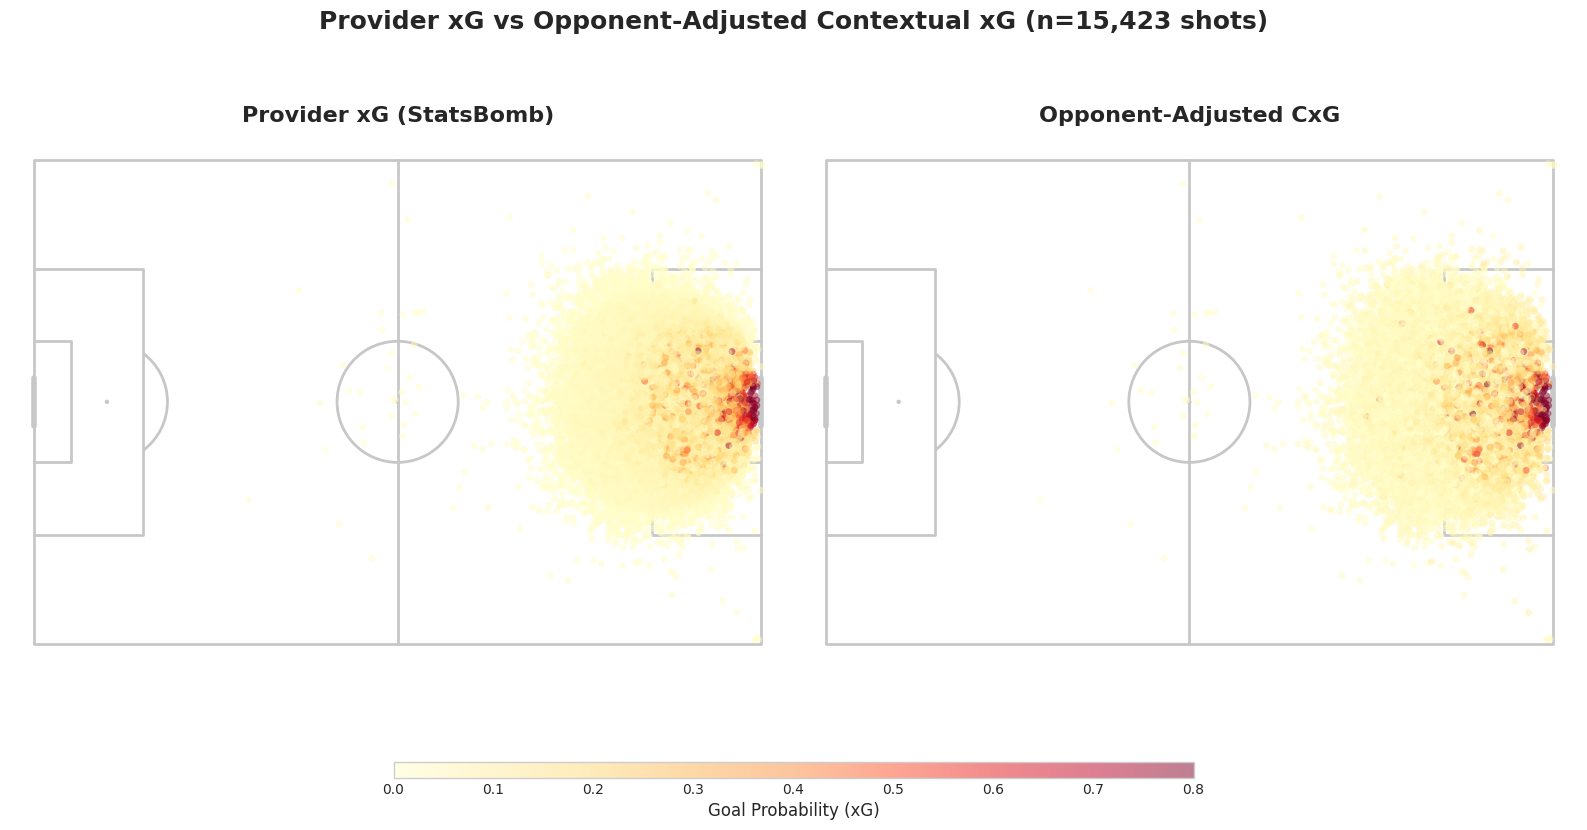

In [3]:
# Create side-by-side pitch comparison using ALL shots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Shared color scale for fair comparison
vmin, vmax = 0, 0.8

for ax, col, title in zip(
    axes,
    ['statsbomb_xg', 'cxg_pred'],
    ['Provider xG (StatsBomb)', 'Opponent-Adjusted CxG']
):
    pitch = Pitch(pitch_type='statsbomb', pitch_color='white', line_color='#c7c7c7')
    pitch.draw(ax=ax)
    
    # Plot ALL shots colored by probability
    scatter = ax.scatter(
        df['location_x'], 
        df['location_y'],
        c=df[col],
        cmap='YlOrRd',
        s=25,
        alpha=0.5,
        vmin=vmin,
        vmax=vmax,
        edgecolors='none'
    )
    ax.set_title(title, fontsize=16, fontweight='bold', pad=10)

# Add single colorbar below both plots
cbar_ax = fig.add_axes([0.25, 0.02, 0.5, 0.02])  # [left, bottom, width, height]
cbar = fig.colorbar(scatter, cax=cbar_ax, orientation='horizontal')
cbar.set_label('Goal Probability (xG)', fontsize=12)
cbar.ax.tick_params(labelsize=10)

plt.suptitle(f'Provider xG vs Opponent-Adjusted Contextual xG (n={len(df):,} shots)', 
             fontsize=18, fontweight='bold', y=0.98)

# Store figure for later export
fig_shot_map = fig
plt.tight_layout(rect=[0, 0.08, 1, 0.95])  # Leave room for colorbar and title
plt.show()

## 4. Calibration Curve Analysis

Calibration curves reveal whether predicted probabilities match observed outcomes. A well-calibrated model's curve follows the diagonal — when it predicts 30% goal probability, goals happen ~30% of the time.

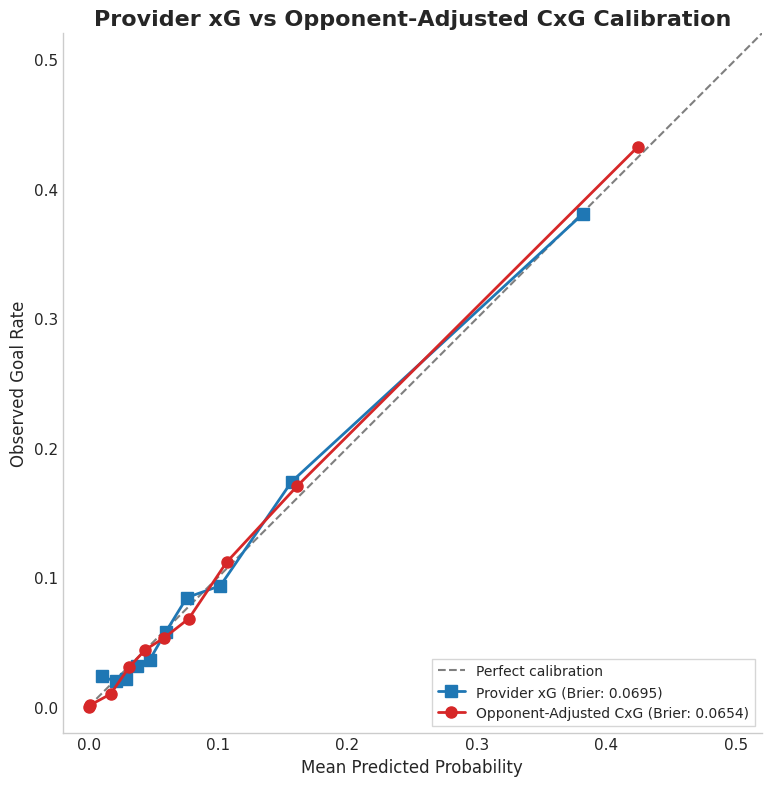


📊 Brier Score Improvement: 6.0% reduction (lower is better)


In [4]:
# Compute calibration curves using equal-frequency bins
# This ensures each bin has similar sample size for robust estimates

n_bins = 10

# Baseline xG calibration
prob_true_xg, prob_pred_xg = calibration_curve(
    df['is_goal'], df['statsbomb_xg'], 
    n_bins=n_bins, strategy='quantile'
)

# CxG calibration  
prob_true_cxg, prob_pred_cxg = calibration_curve(
    df['is_goal'], df['cxg_pred'],
    n_bins=n_bins, strategy='quantile'
)

# Calculate Brier scores (overall)
brier_xg = brier_score_loss(df['is_goal'], df['statsbomb_xg'])
brier_cxg = brier_score_loss(df['is_goal'], df['cxg_pred'])

# Plot
fig, ax = plt.subplots(figsize=(8, 8))

# Perfect calibration reference
ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, label='Perfect calibration', linewidth=1.5)

# Model curves
ax.plot(prob_pred_xg, prob_true_xg, 's-', color='#1f77b4', 
        label=f'Provider xG (Brier: {brier_xg:.4f})', linewidth=2, markersize=8)
ax.plot(prob_pred_cxg, prob_true_cxg, 'o-', color='#d62728',
        label=f'Opponent-Adjusted CxG (Brier: {brier_cxg:.4f})', linewidth=2, markersize=8)

ax.set_xlabel('Mean Predicted Probability')
ax.set_ylabel('Observed Goal Rate')
ax.set_title('Provider xG vs Opponent-Adjusted CxG Calibration', fontsize=16, fontweight='bold')
ax.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='#cccccc')

# Zoom in on the relevant range where most data lies
ax.set_xlim(-0.02, 0.52)
ax.set_ylim(-0.02, 0.52)
ax.set_aspect('equal')

# Store figure for later export
fig_calibration = fig
plt.tight_layout()
plt.show()

# Print improvement
pct_improvement = 100 * (brier_xg - brier_cxg) / brier_xg
print(f"\n📊 Brier Score Improvement: {pct_improvement:.1f}% reduction (lower is better)")

## 5. Slice Performance: Pressure vs No Pressure

Context matters. Shots taken under defensive pressure are harder to convert — does our opponent-adjusted CxG capture this better than provider xG?

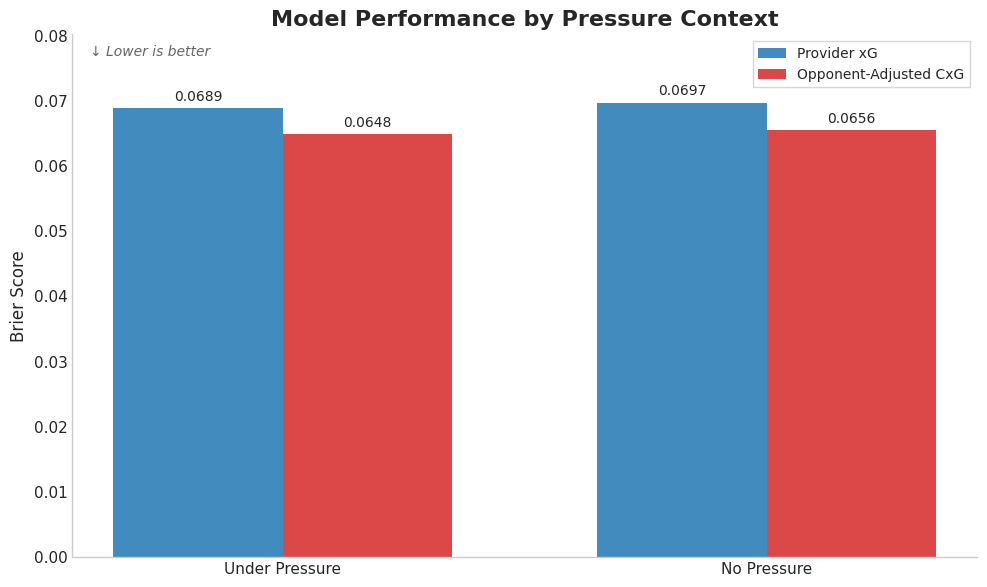


📊 Sample sizes:
   Under pressure: 3,395 shots
   No pressure: 12,028 shots


In [5]:
# Split data by pressure state
df_pressure = df[df['under_pressure'] == True]
df_no_pressure = df[df['under_pressure'] == False]

# Compute Brier scores for each slice
results = {
    'Under Pressure': {
        'Provider xG': brier_score_loss(df_pressure['is_goal'], df_pressure['statsbomb_xg']),
        'Adjusted CxG': brier_score_loss(df_pressure['is_goal'], df_pressure['cxg_pred'])
    },
    'No Pressure': {
        'Provider xG': brier_score_loss(df_no_pressure['is_goal'], df_no_pressure['statsbomb_xg']),
        'Adjusted CxG': brier_score_loss(df_no_pressure['is_goal'], df_no_pressure['cxg_pred'])
    }
}

# Prepare data for plotting
slices = ['Under Pressure', 'No Pressure']
x = np.arange(len(slices))
width = 0.35

brier_xg_vals = [results[s]['Provider xG'] for s in slices]
brier_cxg_vals = [results[s]['Adjusted CxG'] for s in slices]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))

bars1 = ax.bar(x - width/2, brier_xg_vals, width, label='Provider xG', color='#1f77b4', alpha=0.85)
bars2 = ax.bar(x + width/2, brier_cxg_vals, width, label='Opponent-Adjusted CxG', color='#d62728', alpha=0.85)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Brier Score')
ax.set_title('Model Performance by Pressure Context', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(slices)
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='#cccccc')

# Annotation: lower is better
ax.text(0.02, 0.98, '↓ Lower is better', transform=ax.transAxes, 
        fontsize=10, va='top', ha='left', color='#666666', style='italic')

ax.set_ylim(0, max(brier_xg_vals + brier_cxg_vals) * 1.15)

# Store figure for later export
fig_pressure = fig
plt.tight_layout()
plt.show()

# Print sample sizes
print(f"\n📊 Sample sizes:")
print(f"   Under pressure: {len(df_pressure):,} shots")
print(f"   No pressure: {len(df_no_pressure):,} shots")

## 6. Long-Range vs Close-Range Calibration

Long-range shots are inherently harder to convert. This plot reveals whether our opponent-adjusted CxG improves calibration specifically for difficult shot types that provider xG might systematically misvalue.

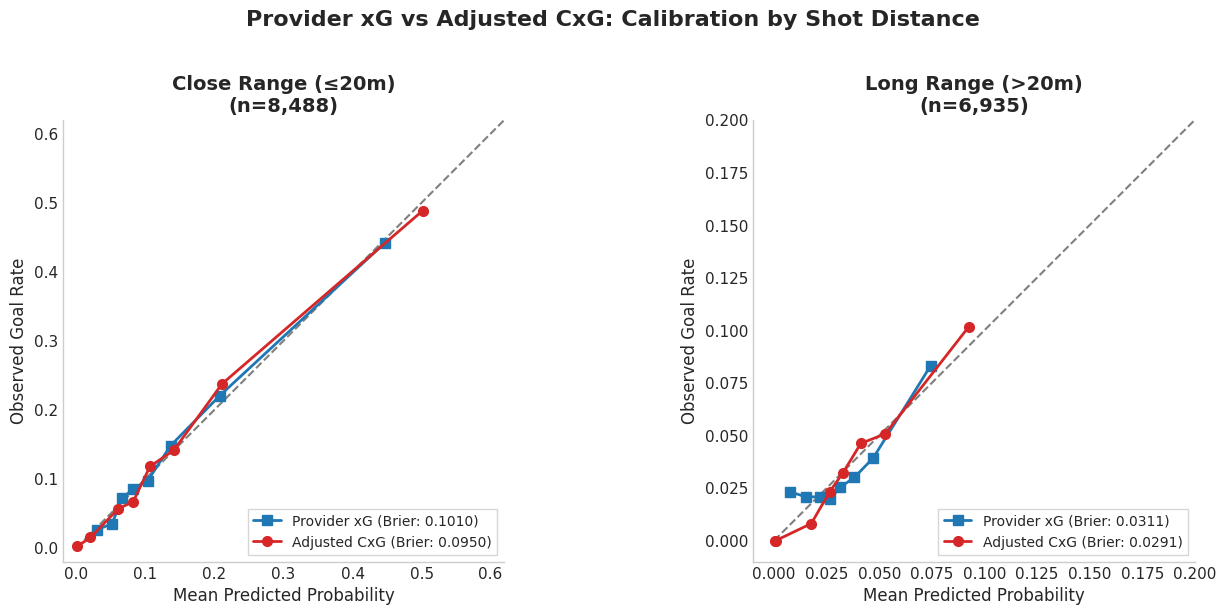

In [6]:
# Define distance threshold (20 meters = ~65.6 feet)
DISTANCE_THRESHOLD = 20

df_close = df[df['shot_distance'] <= DISTANCE_THRESHOLD]
df_long = df[df['shot_distance'] > DISTANCE_THRESHOLD]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

for ax, df_slice, title in zip(
    axes,
    [df_close, df_long],
    [f'Close Range (≤{DISTANCE_THRESHOLD}m)', f'Long Range (>{DISTANCE_THRESHOLD}m)']
):
    # Perfect calibration reference
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.5, linewidth=1.5)
    
    # Only plot if we have enough data
    if len(df_slice) >= 100:
        # Provider xG
        prob_true, prob_pred = calibration_curve(
            df_slice['is_goal'], df_slice['statsbomb_xg'],
            n_bins=8, strategy='quantile'
        )
        brier = brier_score_loss(df_slice['is_goal'], df_slice['statsbomb_xg'])
        ax.plot(prob_pred, prob_true, 's-', color='#1f77b4',
                label=f'Provider xG (Brier: {brier:.4f})', linewidth=2, markersize=7)
        
        # Opponent-Adjusted CxG
        prob_true, prob_pred = calibration_curve(
            df_slice['is_goal'], df_slice['cxg_pred'],
            n_bins=8, strategy='quantile'
        )
        brier = brier_score_loss(df_slice['is_goal'], df_slice['cxg_pred'])
        ax.plot(prob_pred, prob_true, 'o-', color='#d62728',
                label=f'Adjusted CxG (Brier: {brier:.4f})', linewidth=2, markersize=7)
    
    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Observed Goal Rate')
    ax.set_title(f'{title}\n(n={len(df_slice):,})', fontsize=14, fontweight='bold')
    ax.legend(loc='lower right', frameon=True, fancybox=False, edgecolor='#cccccc')
    
# Set appropriate axis limits for each subplot
# Close range has higher xG values, long range clusters near 0
axes[0].set_xlim(-0.02, 0.62)  # Close range
axes[0].set_ylim(-0.02, 0.62)
axes[0].set_aspect('equal')
axes[1].set_xlim(-0.01, 0.20)  # Long range - much lower probabilities
axes[1].set_ylim(-0.01, 0.20)
axes[1].set_aspect('equal')

plt.suptitle('Provider xG vs Adjusted CxG: Calibration by Shot Distance', fontsize=16, fontweight='bold', y=1.02)

# Store figure for later export
fig_distance = fig
plt.tight_layout()
plt.show()

## 7. Export High-Resolution Figures

Save all figures as 300 DPI PNGs for LinkedIn/portfolio use.

In [7]:
# Export all figures at 300 DPI
figures = {
    'cxg_vs_xg_shot_map.png': fig_shot_map,
    'calibration_curves.png': fig_calibration,
    'pressure_brier_comparison.png': fig_pressure,
    'distance_calibration.png': fig_distance
}

for filename, fig in figures.items():
    filepath = OUTPUT_DIR / filename
    fig.savefig(filepath, dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none')
    print(f"✓ Saved: {filepath}")

print(f"\n🎉 All figures exported to: {OUTPUT_DIR.resolve()}")

✓ Saved: ../outputs/analysis/cxg/plots/cxg_vs_xg_shot_map.png
✓ Saved: ../outputs/analysis/cxg/plots/calibration_curves.png
✓ Saved: ../outputs/analysis/cxg/plots/pressure_brier_comparison.png
✓ Saved: ../outputs/analysis/cxg/plots/distance_calibration.png

🎉 All figures exported to: /workspaces/opponent-adjusted-metrics/outputs/analysis/cxg/plots


---

## Summary

| Figure | Purpose | Key Insight |
|--------|---------|-------------|
| Shot Map | Visual comparison of xG vs CxG | Shows how context changes shot valuations |
| Calibration Curve | Model reliability | CxG predictions match actual outcomes better |
| Pressure Analysis | Context-specific performance | CxG handles pressure situations more accurately |
| Distance Calibration | Slice-level validation | Improvements are consistent across shot types |

**For LinkedIn:** Export 2-3 figures maximum. The shot map and calibration curve tell the core story.